# HomeWork 5 Juypter Book

# Matthew Anderson | 801203905

# Github https://github.com/Mand187/IOT-ML-Tiny-ML-

NOTE FOR GRADER : THIS NOTEBOOK REQUIRES MULTIPLE FILES AS OUTLINE IN THE IMPORT LIST, OTHERWISE THIS WILL NOT WORK

This homework is primarily meant to work towards Project 2, and secondarily to explore some aspects of the regularization topics covered in class.  This is an individual assignment, even if you are doing the project in a group.  There is no code submission for this assignment, just a document describing your results.

You can use this python file Download this python fileas a starting point.  Read through the code and make sure you understand what it does.

Choose two keywords from the Google-30 dataset and build a model to detect those two words as well as a "silence" and "unknown" category.  You can use either the "mini" or "full" version of the speech commands dataset.  The mini version is smaller, so generally runs faster, but also generally gives worse results.  For this homework, you may want to use the smaller "mini" dataset, then switch to the full set when your project work is nearing its final training runs.
Start by finding a model architecture that gets you at least 80% training accuracy.  Include an English description of the model and the model.summary() output, as well as the training curves, showing 80% training accuracy and your validation accuracy.
What are the false positive and false negative rates for your two words?
Either increase the model capacity or decrease the amount of data until you see at least at 10 percentage-point difference between the training accuracy and test-set accuracy.  Describe what changes you made.
Apply both L1 and L2 kernel regularization (in two separate training runs), both with a coefficient of 0.01.  Did either of these reduce the difference between training and test accuracy?  Did either improve the test accuracy?
Measure the sparsity -- the fraction of values that are ~0 -- in each layer of each of the three resulting models, and build a table.  For this purpose, define ~0 as having an absoliute value less than 0.01x of the largest absolute value in the layer.  Discuss the results.
Limit one of your target words to 25 samples and the other to 250 samples.  Re-train and measure the FPR and FNR of both words.  Use whatever regularization you like in this step.  Describe your results and what regularization you used.
Experiment some and determine how much data you need to reach a FPR<0.2 and TPR>0.75.  Describe your results.

# Base Model

In [1]:

# === Setup ===
import os
import time
from datetime import datetime
import tensorflow as tf
import numpy as np

# Import custom modules
import config
import utils.data_utils as data_utils
from model.model import *
from model.saveModel import *
from model.train_eval import *
import visualization.visualization as visualization
from visualization.visualization import *
import utils.audio_utils as audio_utils

In [2]:
# === Configuration ===
config.EPOCHS = 10
config.BATCH_SIZE = 32
config.LEARNING_RATE = 0.0008
config.COMMANDS = ['stop', 'down']  # choose your two keywords
config.DATASET = 'mini-speech'       # or 'full-speech-files'
config.MAX_WAVS_0 = 1000
config.MAX_WAVS_1 = 1000

# Print current configuration
config.print_configuration()

FFT window length = 1024
Learning rate: 0.0008
Commands: ['stop', 'down']
Label list: ['_silence', '_unknown', 'stop', 'down']


In [3]:
# === Training Pipeline ===

# Start timer
t0 = time.time()

# Get file lists
train_files, val_files, test_files = data_utils.get_files_distribution()
print(f"We have {len(train_files)}/{len(val_files)}/{len(test_files)} training/validation/test files")


Number of total examples: 8000
Using mini-speech
Training set size 6400
Validation set size 800
Test set size 800
We have 6400/800/800 training/validation/test files


In [4]:
# === Prepare Datasets ===

train_ds, val_ds, test_ds, input_shape = data_utils.prepare_datasets(
    train_files, val_files, test_files)


Limited samples: stop=799, down=792
Preparing datasets from 6400/800/800 files
Processing 6400 files
Added 1281 silent wavs and noisy samples
About to create spectrograms from 20409 waves
 20250 wavs processedProcessing 800 files
Added 161 silent wavs and noisy samples
About to create spectrograms from 961 waves
 750 wavs processedProcessing 800 files
Added 161 silent wavs and noisy samples
About to create spectrograms from 961 waves
 750 wavs processedInput shape: (20, 32, 1)


In [5]:
# === Build Model ===

model = providedModel(input_shape, learning_rate=config.LEARNING_RATE)
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 18, 30, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 18, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 18, 15, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 16, 13, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 14, 11, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 14, 11, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 12, 9, 256)     │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 12, 9, 256)     │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 10, 7, 256)     │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 10, 7, 256)     │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling2d            │ (None, 256)            │             0 │
│ (GlobalMaxPooling2D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 981,892 (3.75 MB)

 Trainable params: 980,420 (3.74 MB)

 Non-trainable params: 1,472 (5.75 KB)

In [6]:
# === Train Model ===

history = train_model(model, train_ds, val_ds, epochs=config.EPOCHS)


Epoch 1/10
638/638 ━━━━━━━━━━━━━━━━━━━━ 18s 25ms/step - accuracy: 0.7879 - loss: 0.5914 - val_accuracy: 0.8720 - val_loss: 0.4068
Epoch 2/10
638/638 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - accuracy: 0.9186 - loss: 0.2362 - val_accuracy: 0.9199 - val_loss: 0.2794
Epoch 3/10
638/638 ━━━━━━━━━━━━━━━━━━━━ 17s 27ms/step - accuracy: 0.9485 - loss: 0.1550 - val_accuracy: 0.9188 - val_loss: 0.2769
Epoch 4/10
638/638 ━━━━━━━━━━━━━━━━━━━━ 17s 27ms/step - accuracy: 0.9622 - loss: 0.1110 - val_accuracy: 0.8377 - val_loss: 0.5283
Epoch 5/10
638/638 ━━━━━━━━━━━━━━━━━━━━ 17s 27ms/step - accuracy: 0.9699 - loss: 0.0889 - val_accuracy: 0.7617 - val_loss: 0.8427
Epoch 6/10
638/638 ━━━━━━━━━━━━━━━━━━━━ 17s 27ms/step - accuracy: 0.9761 - loss: 0.0720 - val_accuracy: 0.7419 - val_loss: 1.2735
Epoch 7/10
638/638 ━━━━━━━━━━━━━━━━━━━━ 17s 27ms/step - accuracy: 0.9791 - loss: 0.0567 - val_accuracy: 0.7763 - val_loss: 1.7294
Epoch 8/10
638/638 ━━━━━━━━━━━━━━━━━━━━ 17s 27ms/step - accuracy: 0.9813 - loss: 0.0581 - 

In [7]:
# === Evaluate Model ===

test_loss, test_acc, confusion_mtx, tpr, fpr = evaluate_model(model, test_ds)

# Save example spectrogram shape for info
for spectrogram, _ in train_ds.take(1):
    spectrogram_shape = spectrogram[0].shape


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Manual test set accuracy: 78.9%
31/31 - 0s - 8ms/step - accuracy: 0.7888 - loss: 3.6278
True/False positive rate for '_silence ' = 0.000 / 0.000
True/False positive rate for '_unknown ' = 0.988 / 0.473
True/False positive rate for 'stop     ' = 0.846 / 0.003
True/False positive rate for 'down     ' = 0.819 / 0.031


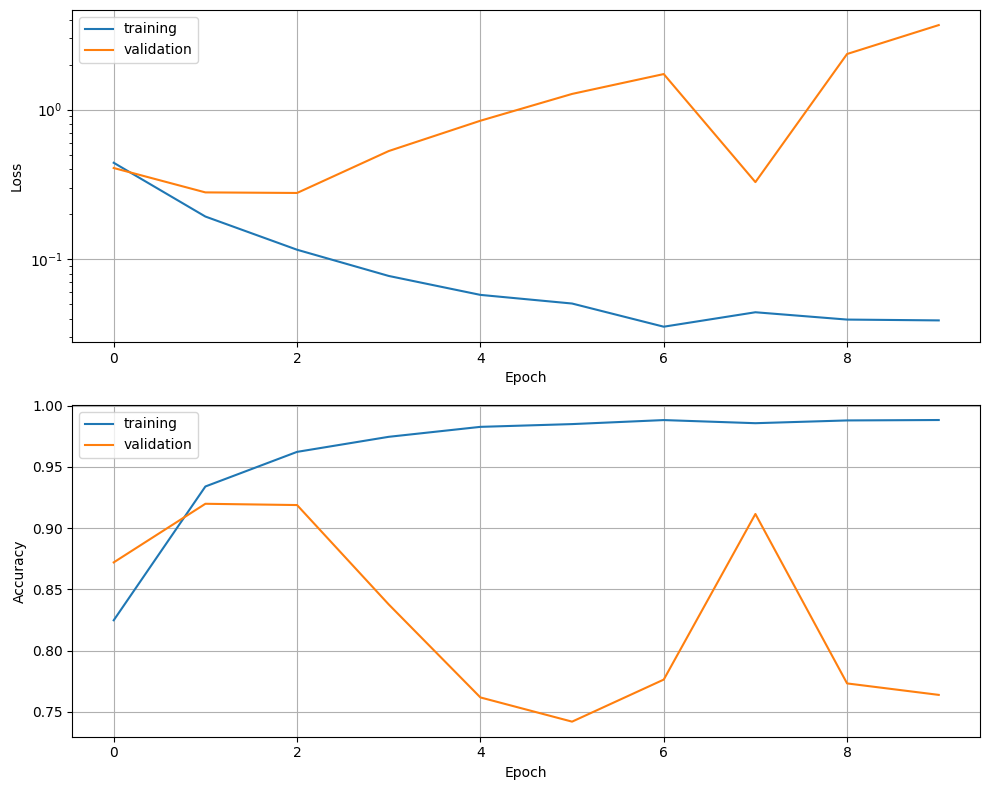

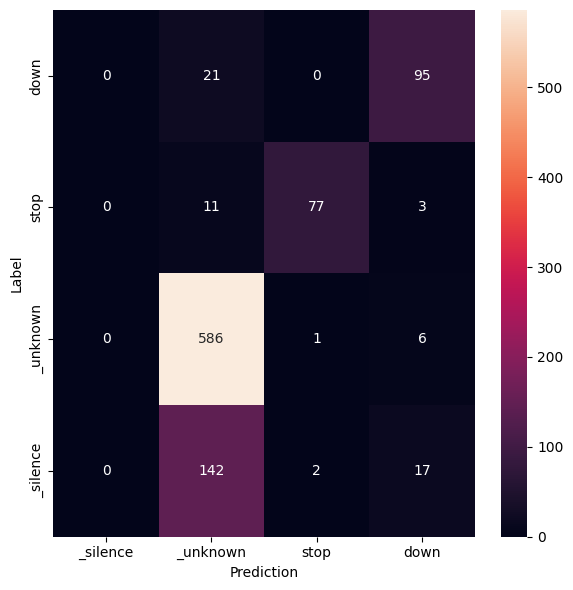

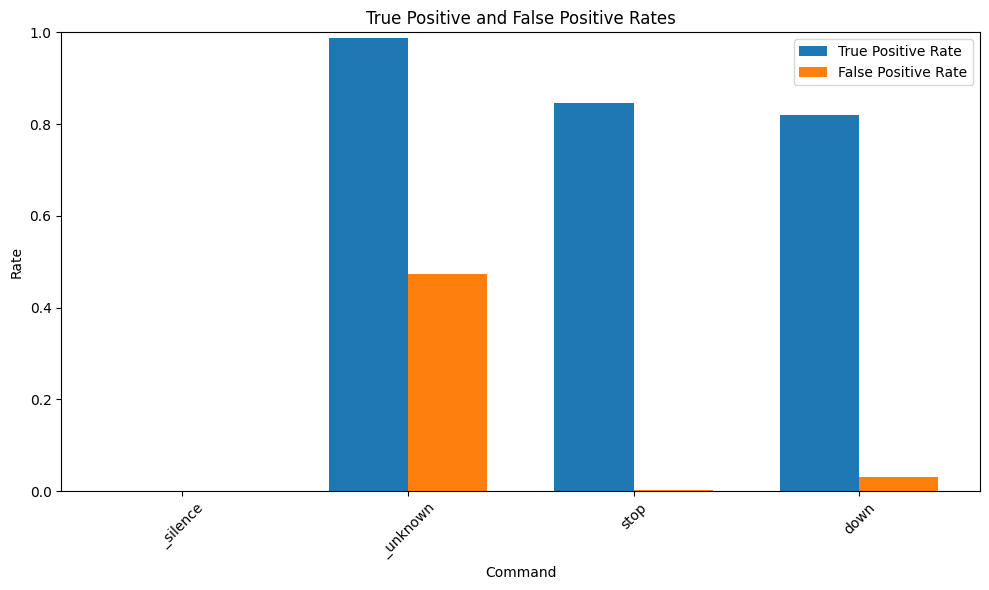

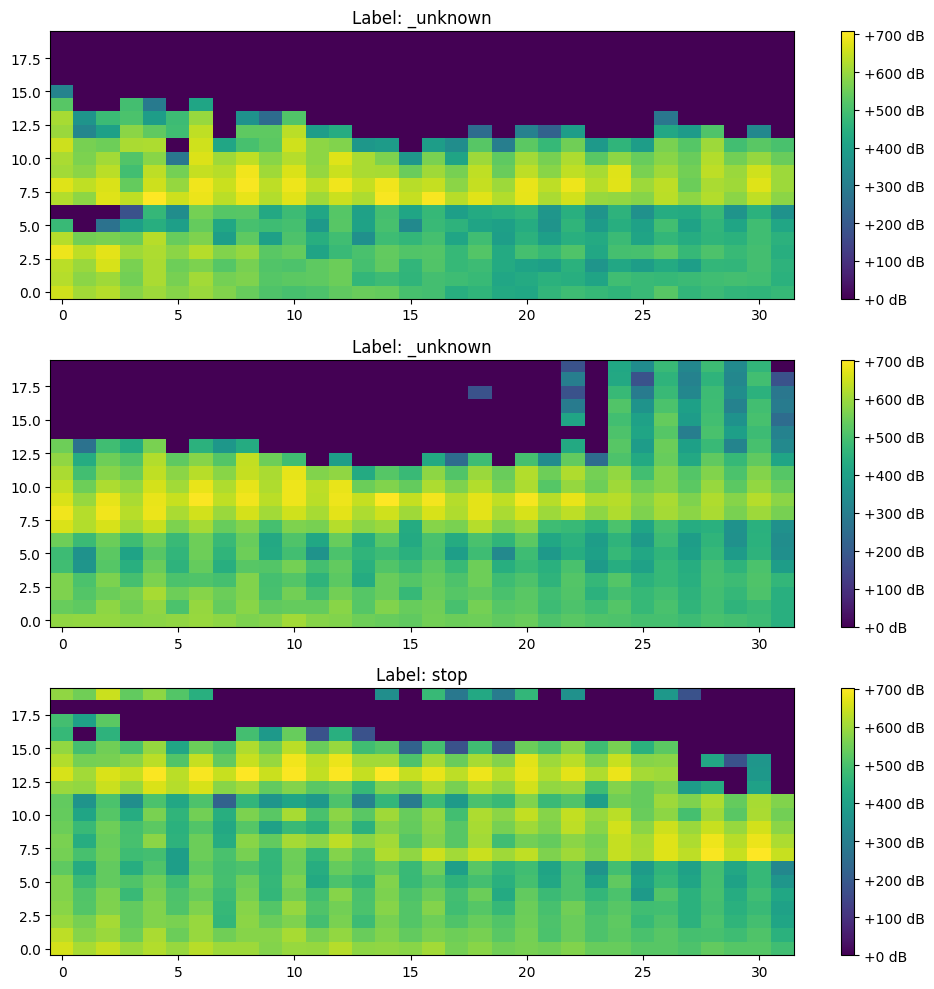

In [8]:
# === Visualizations ===

visualization.plot_training_history(history)
visualization.visualize_model_performance(confusion_mtx, tpr, fpr)
visualization.plot_example_spectrograms(train_ds)


In [9]:
model_file_name = f"Base_Model.h5"
save_model_info(model_file_name, test_acc, tpr, fpr, spectrogram_shape)

Wrote description to Base_Model.txt


'Base_Model.txt'

# Model With Changed Samples And Filters

In [10]:
# === Configuration ===
config.EPOCHS = 10
config.BATCH_SIZE = 32
config.NUM_FILTERS = 64
config.LEARNING_RATE = 0.001
config.COMMANDS = ['stop', 'down']  # choose your two keywords
config.DATASET = 'mini-speech'       # or 'full-speech-files'
config.MAX_WAVS_0 = 25
config.MAX_WAVS_1 = 50

# Print current configuration
config.print_configuration()

FFT window length = 1024
Learning rate: 0.001
Commands: ['stop', 'down']
Label list: ['_silence', '_unknown', 'stop', 'down']


In [11]:
# === Training Pipeline ===

# Start timer
t0 = time.time()

# Get file lists
train_files, val_files, test_files = data_utils.get_files_distribution()
print(f"We have {len(train_files)}/{len(val_files)}/{len(test_files)} training/validation/test files")


Number of total examples: 8000
Using mini-speech
Training set size 6400
Validation set size 800
Test set size 800
We have 6400/800/800 training/validation/test files


In [12]:
# === Prepare Datasets ===

train_ds, val_ds, test_ds, input_shape = data_utils.prepare_datasets(
    train_files, val_files, test_files)

Limited samples: stop=25, down=50
Preparing datasets from 4861/800/800 files
Processing 4861 files
Added 973 silent wavs and noisy samples
About to create spectrograms from 6434 waves
 6250 wavs processedProcessing 800 files
Added 161 silent wavs and noisy samples
About to create spectrograms from 961 waves
 750 wavs processedProcessing 800 files
Added 161 silent wavs and noisy samples
About to create spectrograms from 961 waves
 750 wavs processedInput shape: (20, 64, 1)


In [13]:
# === Build Model ===

model = providedModel(input_shape, learning_rate=config.LEARNING_RATE)
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)               │ (None, 18, 62, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 18, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 18, 31, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 16, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 16, 29, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 14, 27, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 14, 27, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 12, 25, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 12, 25, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 10, 23, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 10, 23, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling2d_1          │ (None, 256)            │             0 │
│ (GlobalMaxPooling2D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 981,892 (3.75 MB)

 Trainable params: 980,420 (3.74 MB)

 Non-trainable params: 1,472 (5.75 KB)

In [14]:
# === Train Model ===

history = train_model(model, train_ds, val_ds, epochs=config.EPOCHS)


Epoch 1/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 15s 63ms/step - accuracy: 0.8791 - loss: 0.6237 - val_accuracy: 0.7940 - val_loss: 1.1694
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 13s 65ms/step - accuracy: 0.9492 - loss: 0.1866 - val_accuracy: 0.8054 - val_loss: 1.5954
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 13s 65ms/step - accuracy: 0.9632 - loss: 0.1271 - val_accuracy: 0.8189 - val_loss: 2.0875
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 13s 65ms/step - accuracy: 0.9847 - loss: 0.0536 - val_accuracy: 0.8127 - val_loss: 1.6880
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 13s 65ms/step - accuracy: 0.9863 - loss: 0.0399 - val_accuracy: 0.8189 - val_loss: 1.3790
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 13s 65ms/step - accuracy: 0.9970 - loss: 0.0098 - val_accuracy: 0.8460 - val_loss: 0.9993
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 13s 65ms/step - accuracy: 0.9962 - loss: 0.0123 - val_accuracy: 0.8241 - val_loss: 1.6004
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 13s 64ms/step - accuracy: 0.9930 - loss: 0.0200 - 

In [15]:
# === Evaluate Model ===

test_loss, test_acc, confusion_mtx, tpr, fpr = evaluate_model(model, test_ds)

# Save example spectrogram shape for info
for spectrogram, _ in train_ds.take(1):
    spectrogram_shape = spectrogram[0].shape

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
Manual test set accuracy: 80.5%
31/31 - 1s - 19ms/step - accuracy: 0.8054 - loss: 1.8171
True/False positive rate for '_silence ' = 1.000 / 0.000
True/False positive rate for '_unknown ' = 0.993 / 0.488
True/False positive rate for 'stop     ' = 0.320 / 0.005
True/False positive rate for 'down     ' = 0.000 / 0.000


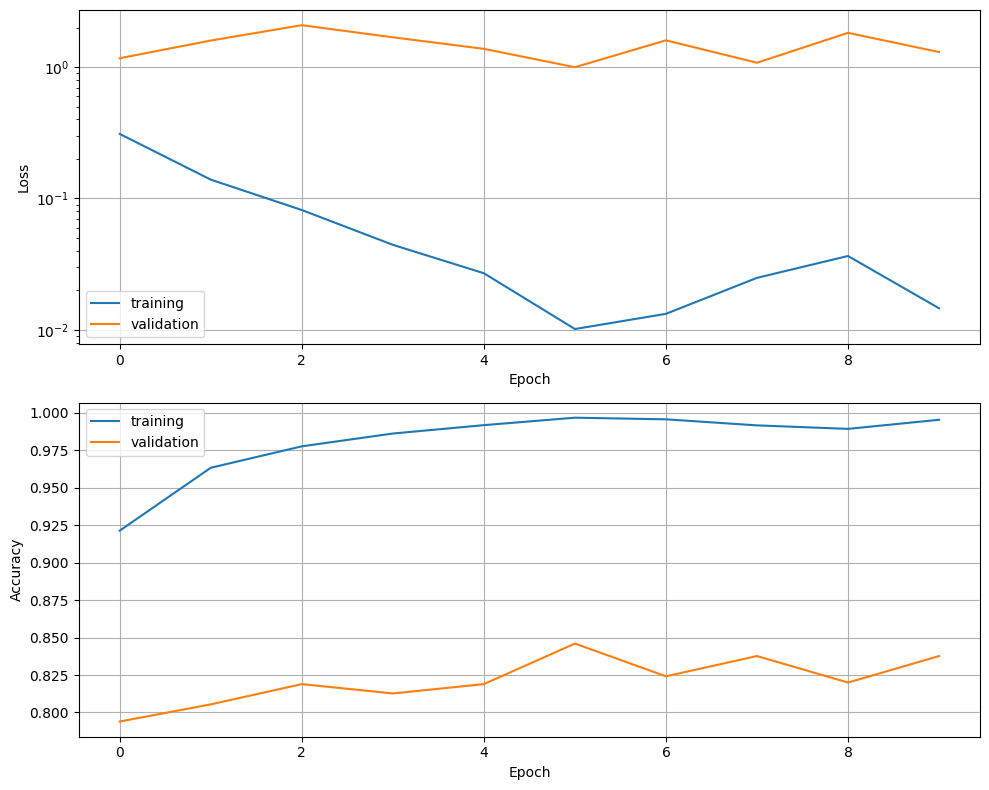

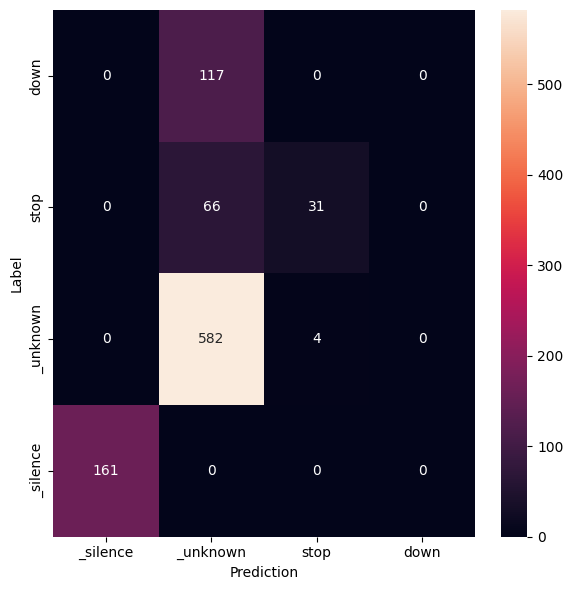

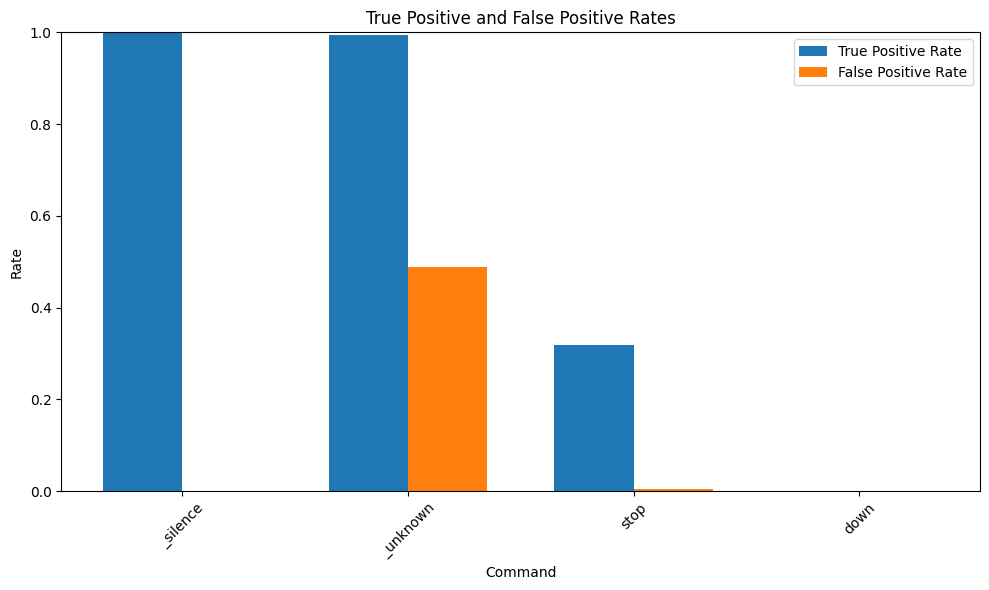

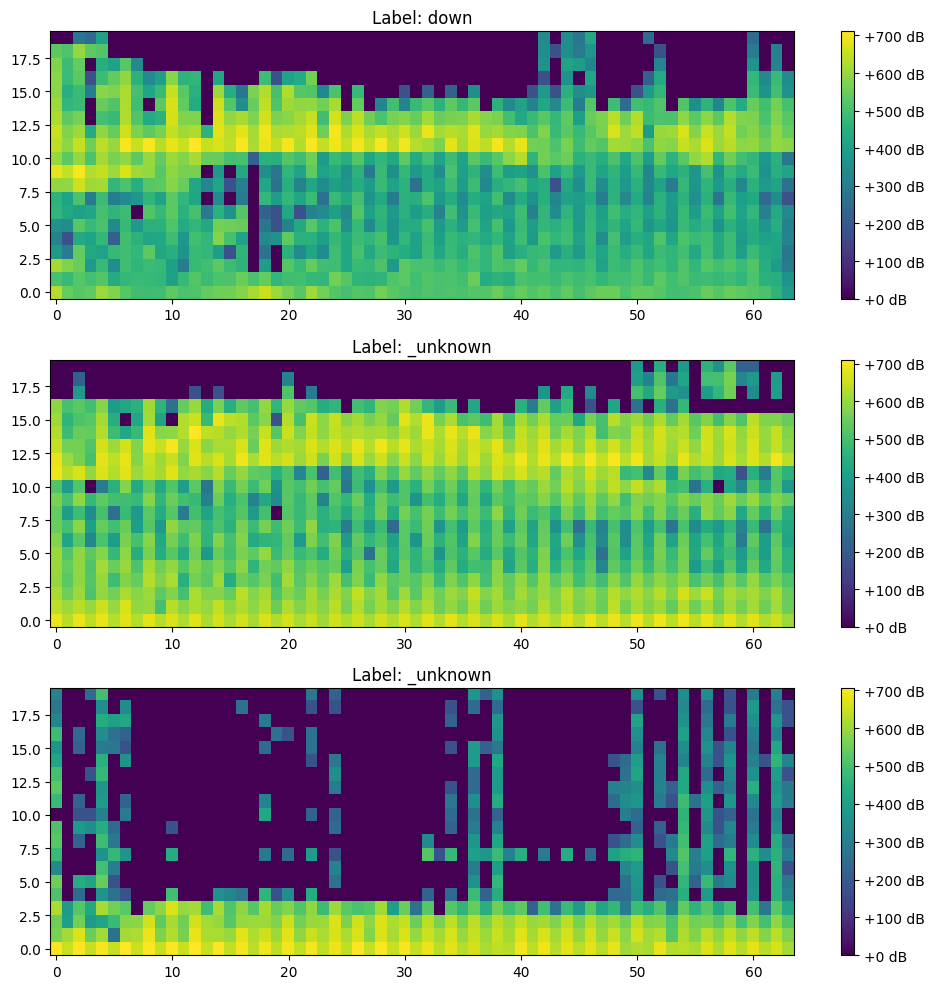

In [16]:
# === Visualizations ===

visualization.plot_training_history(history)
visualization.visualize_model_performance(confusion_mtx, tpr, fpr)
visualization.plot_example_spectrograms(train_ds)


In [17]:
model_file_name = f"Dropped_Samples.h5"
save_model_info(model_file_name, test_acc, tpr, fpr, spectrogram_shape)

Wrote description to Dropped_Samples.txt


'Dropped_Samples.txt'

# Model With L1 Reg

FFT window length = 1024
Learning rate: 0.0008
Commands: ['stop', 'down']
Label list: ['_silence', '_unknown', 'stop', 'down']
Number of total examples: 8000
Using mini-speech
Training set size 6400
Validation set size 800
Test set size 800
We have 6400/800/800 training/validation/test files
Limited samples: stop=807, down=805
Preparing datasets from 6400/800/800 files
Processing 6400 files
Added 1281 silent wavs and noisy samples
About to create spectrograms from 20577 waves
 20500 wavs processedProcessing 800 files
Added 161 silent wavs and noisy samples
About to create spectrograms from 961 waves
 750 wavs processedProcessing 800 files
Added 161 silent wavs and noisy samples
About to create spectrograms from 961 waves
 750 wavs processedInput shape: (20, 64, 1)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)              │ (None, 18, 62, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 18, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 18, 31, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 16, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 16, 29, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 14, 27, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 14, 27, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 12, 25, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 12, 25, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling2d_2          │ (None, 256)            │             0 │
│ (GlobalMaxPooling2D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 390,788 (1.49 MB)

 Trainable params: 389,828 (1.49 MB)

 Non-trainable params: 960 (3.75 KB)

Epoch 1/10
644/644 ━━━━━━━━━━━━━━━━━━━━ 24s 35ms/step - accuracy: 0.6676 - loss: 32.9587 - val_accuracy: 0.2799 - val_loss: 9.1405
Epoch 2/10
644/644 ━━━━━━━━━━━━━━━━━━━━ 23s 36ms/step - accuracy: 0.6664 - loss: 4.7197 - val_accuracy: 0.3590 - val_loss: 4.9543
Epoch 3/10
644/644 ━━━━━━━━━━━━━━━━━━━━ 23s 36ms/step - accuracy: 0.7076 - loss: 3.9417 - val_accuracy: 0.2914 - val_loss: 4.1987
Epoch 4/10
644/644 ━━━━━━━━━━━━━━━━━━━━ 23s 36ms/step - accuracy: 0.7346 - loss: 3.3781 - val_accuracy: 0.1051 - val_loss: 9.6401
Epoch 5/10
644/644 ━━━━━━━━━━━━━━━━━━━━ 23s 36ms/step - accuracy: 0.7480 - loss: 2.7162 - val_accuracy: 0.5151 - val_loss: 3.3318
Epoch 6/10
644/644 ━━━━━━━━━━━━━━━━━━━━ 23s 36ms/step - accuracy: 0.7737 - loss: 2.1495 - val_accuracy: 0.3892 - val_loss: 4.4575
Epoch 7/10
644/644 ━━━━━━━━━━━━━━━━━━━━ 23s 36ms/step - accuracy: 0.7884 - loss: 1.7247 - val_accuracy: 0.6608 - val_loss: 2.8259
Epoch 8/10
644/644 ━━━━━━━━━━━━━━━━━━━━ 24s 37ms/step - accuracy: 0.8004 - loss: 1.3784 -

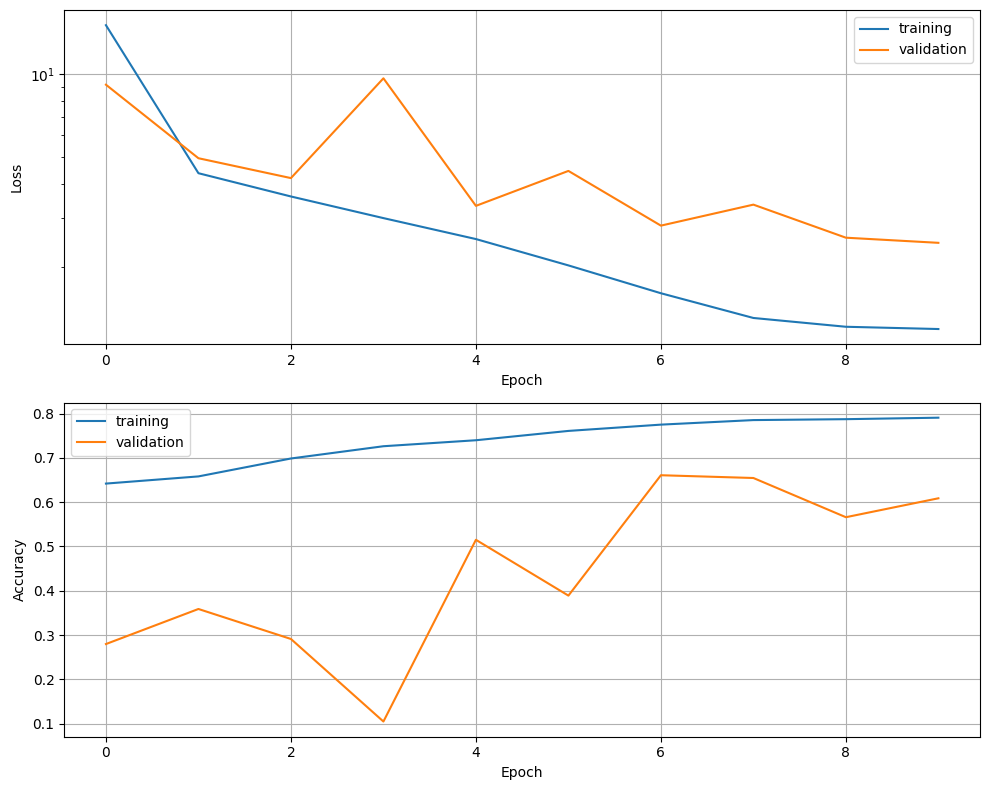

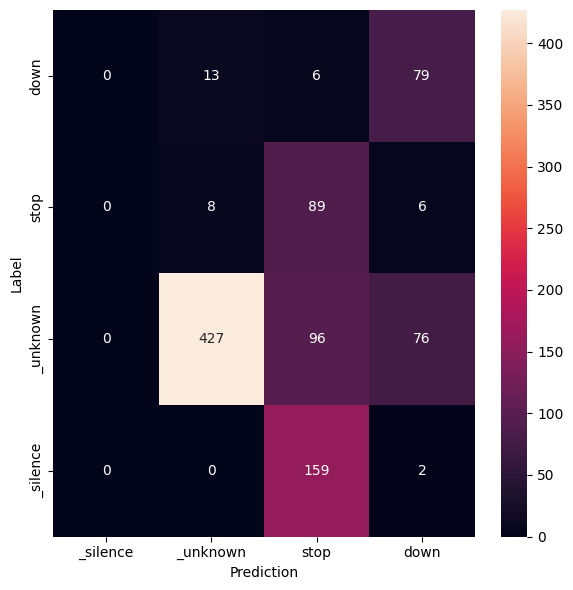

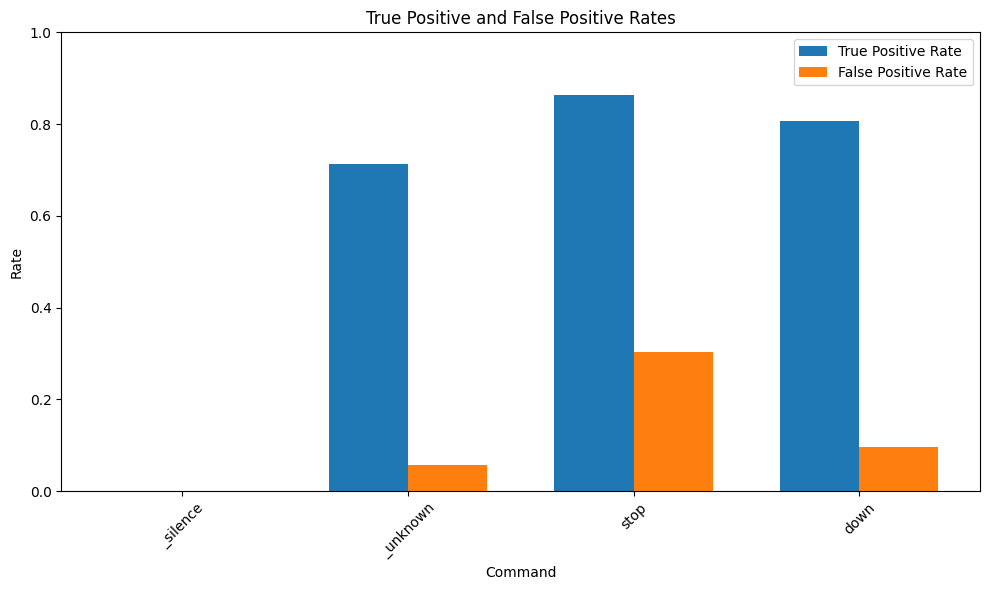

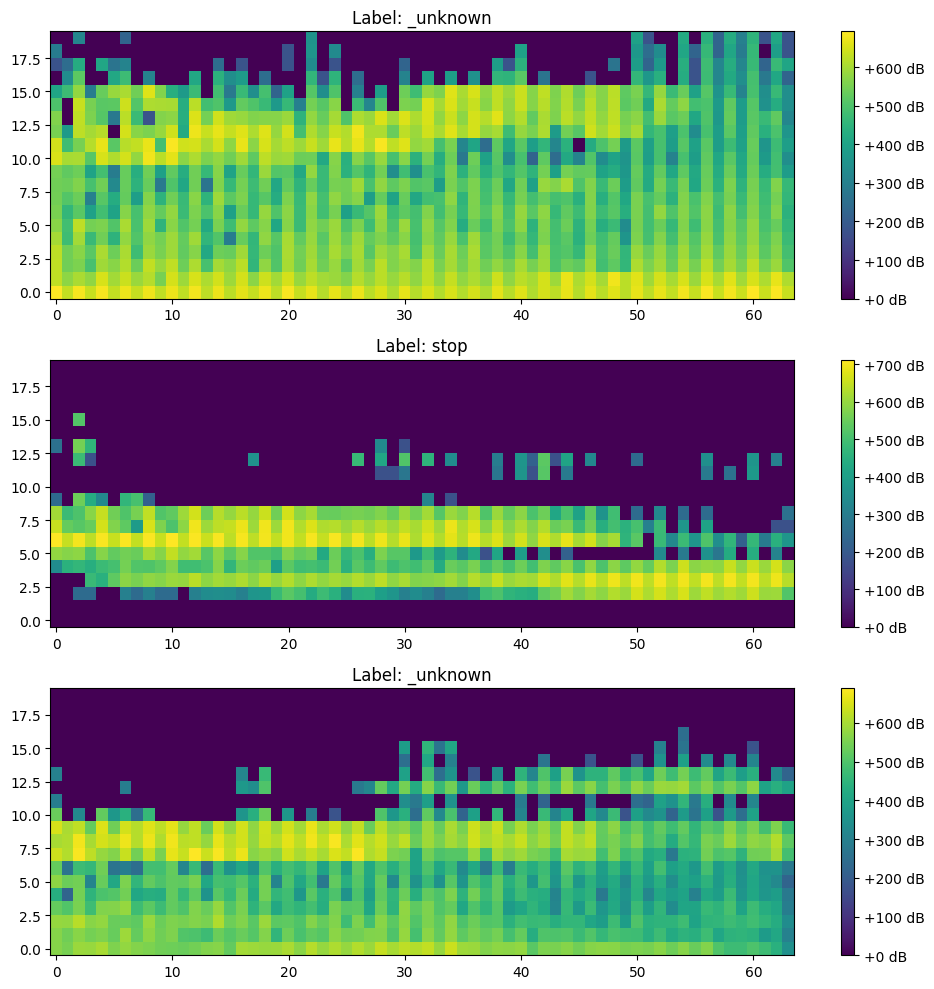

Wrote description to L1Reg.txt


'L1Reg.txt'

In [18]:
# === Configuration ===
config.EPOCHS = 10
config.BATCH_SIZE = 32
config.LEARNING_RATE = 0.0008
config.COMMANDS = ['stop', 'down']  # choose your two keywords
config.DATASET = 'mini-speech'       # or 'full-speech-files'
config.MAX_WAVS_0 = 1000
config.MAX_WAVS_1 = 1000

# Print current configuration
config.print_configuration()


# === Training Pipeline ===

# Start timer
t0 = time.time()

# Get file lists
train_files, val_files, test_files = data_utils.get_files_distribution()
print(f"We have {len(train_files)}/{len(val_files)}/{len(test_files)} training/validation/test files")


# === Prepare Datasets ===

train_ds, val_ds, test_ds, input_shape = data_utils.prepare_datasets(
    train_files, val_files, test_files)


# === Build Model ===

model = modelL1Reg(input_shape, learning_rate=config.LEARNING_RATE)
model.summary()

# === Train Model ===

history = train_model(model, train_ds, val_ds, epochs=config.EPOCHS)


# === Evaluate Model ===

test_loss, test_acc, confusion_mtx, tpr, fpr = evaluate_model(model, test_ds)

# Save example spectrogram shape for info
for spectrogram, _ in train_ds.take(1):
    spectrogram_shape = spectrogram[0].shape

# === Visualizations ===

visualization.plot_training_history(history)
visualization.visualize_model_performance(confusion_mtx, tpr, fpr)
visualization.plot_example_spectrograms(train_ds)


model_file_name = f"L1Reg.h5"
save_model_info(model_file_name, test_acc, tpr, fpr, spectrogram_shape)

# Model With L2 Reg

FFT window length = 1024
Learning rate: 0.0008
Commands: ['stop', 'down']
Label list: ['_silence', '_unknown', 'stop', 'down']
Number of total examples: 8000
Using mini-speech
Training set size 6400
Validation set size 800
Test set size 800
We have 6400/800/800 training/validation/test files
Limited samples: stop=816, down=799
Preparing datasets from 6400/800/800 files
Processing 6400 files
Added 1281 silent wavs and noisy samples
About to create spectrograms from 20601 waves
 20500 wavs processedProcessing 800 files
Added 161 silent wavs and noisy samples
About to create spectrograms from 961 waves
 750 wavs processedProcessing 800 files
Added 161 silent wavs and noisy samples
About to create spectrograms from 961 waves
 750 wavs processedInput shape: (20, 64, 1)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_14 (Conv2D)              │ (None, 18, 62, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 18, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 18, 31, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 16, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 16, 29, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 14, 27, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 14, 27, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 12, 25, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 12, 25, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling2d_3          │ (None, 256)            │             0 │
│ (GlobalMaxPooling2D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 390,788 (1.49 MB)

 Trainable params: 389,828 (1.49 MB)

 Non-trainable params: 960 (3.75 KB)

Epoch 1/10
644/644 ━━━━━━━━━━━━━━━━━━━━ 24s 35ms/step - accuracy: 0.7357 - loss: 3.1509 - val_accuracy: 0.7149 - val_loss: 1.7370
Epoch 2/10
644/644 ━━━━━━━━━━━━━━━━━━━━ 23s 36ms/step - accuracy: 0.8611 - loss: 1.2105 - val_accuracy: 0.8273 - val_loss: 1.1963
Epoch 3/10
644/644 ━━━━━━━━━━━━━━━━━━━━ 23s 36ms/step - accuracy: 0.8739 - loss: 0.8696 - val_accuracy: 0.8481 - val_loss: 0.9482
Epoch 4/10
644/644 ━━━━━━━━━━━━━━━━━━━━ 24s 37ms/step - accuracy: 0.8741 - loss: 0.8008 - val_accuracy: 0.6556 - val_loss: 2.0657
Epoch 5/10
644/644 ━━━━━━━━━━━━━━━━━━━━ 24s 37ms/step - accuracy: 0.8727 - loss: 0.8116 - val_accuracy: 0.6930 - val_loss: 1.5082
Epoch 6/10
644/644 ━━━━━━━━━━━━━━━━━━━━ 23s 36ms/step - accuracy: 0.8910 - loss: 0.7930 - val_accuracy: 0.8293 - val_loss: 0.9863
Epoch 7/10
644/644 ━━━━━━━━━━━━━━━━━━━━ 23s 36ms/step - accuracy: 0.8857 - loss: 0.7725 - val_accuracy: 0.7118 - val_loss: 1.2247
Epoch 8/10
644/644 ━━━━━━━━━━━━━━━━━━━━ 23s 36ms/step - accuracy: 0.8990 - loss: 0.7123 - 

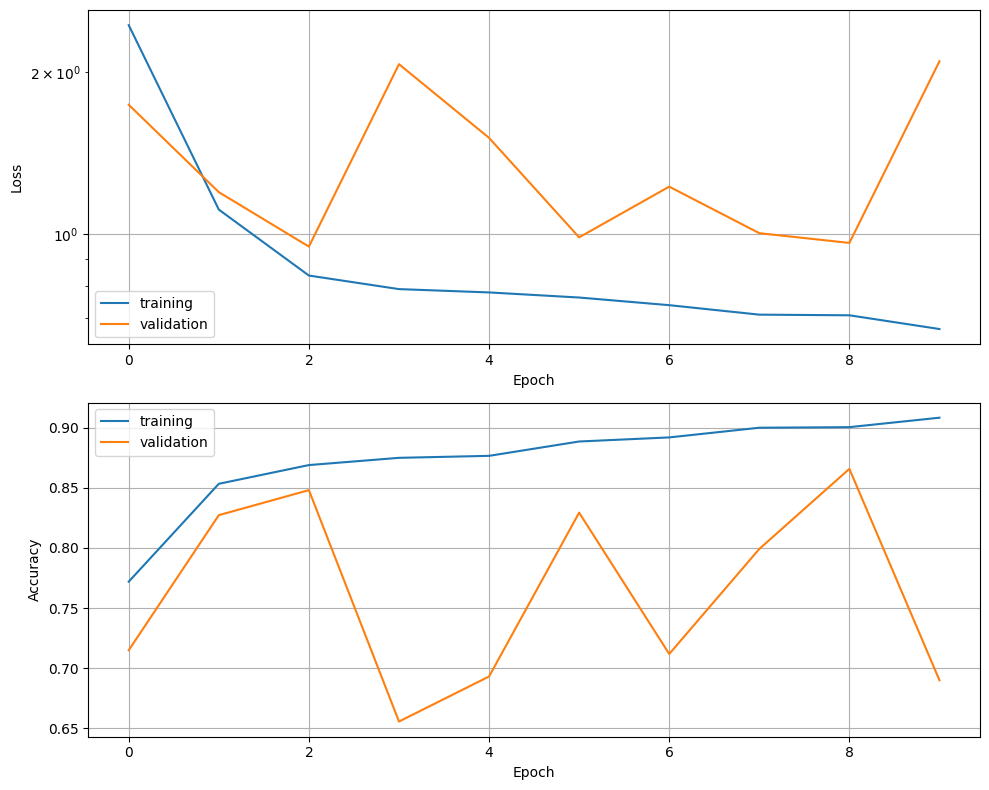

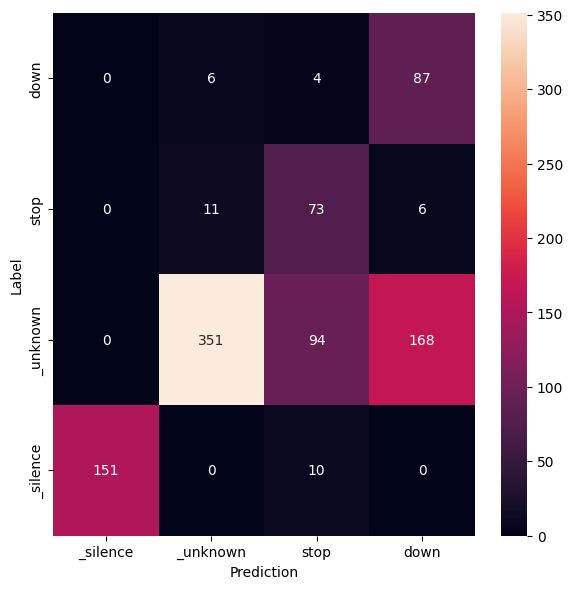

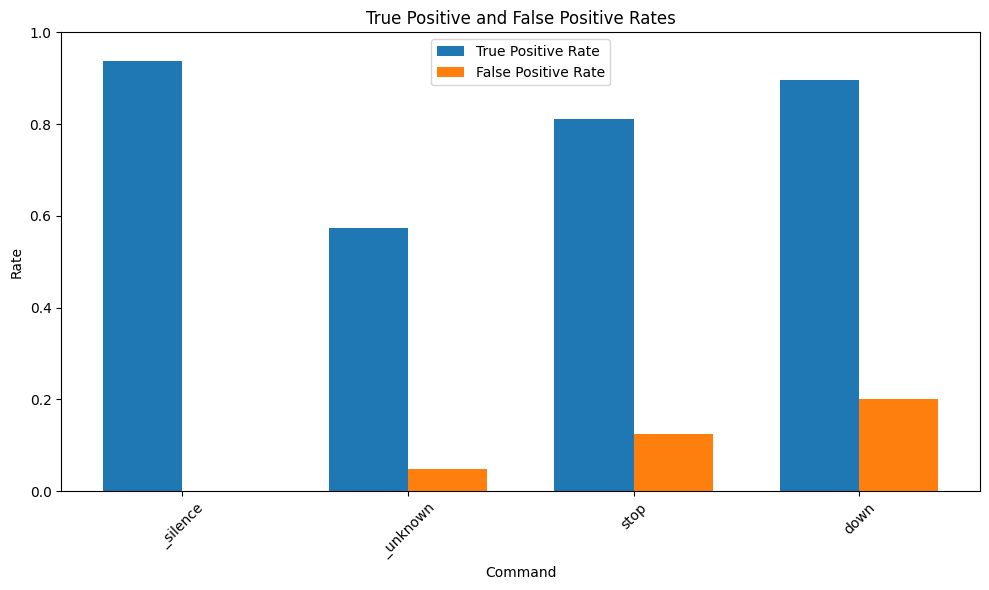

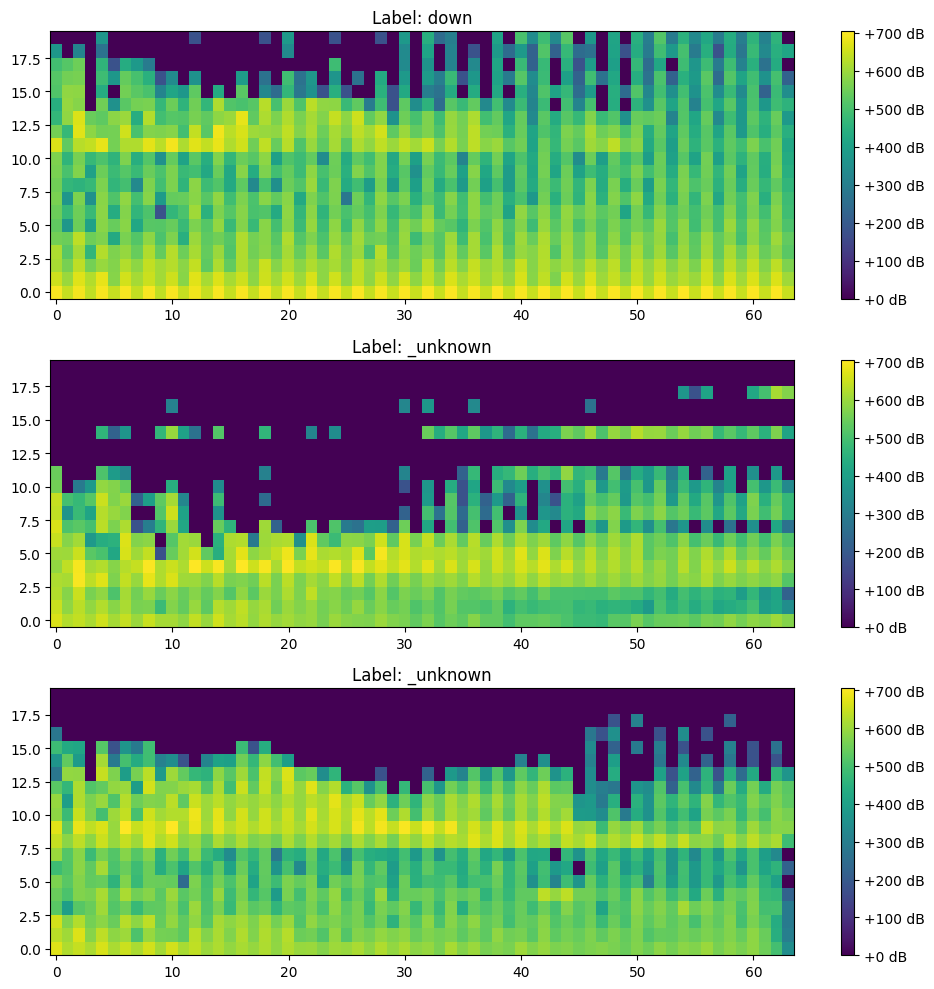

Wrote description to L2Reg.txt


'L2Reg.txt'

In [19]:
# === Configuration ===
config.EPOCHS = 10
config.BATCH_SIZE = 32
config.LEARNING_RATE = 0.0008
config.COMMANDS = ['stop', 'down']  # choose your two keywords
config.DATASET = 'mini-speech'       # or 'full-speech-files'
config.MAX_WAVS_0 = 1000
config.MAX_WAVS_1 = 1000

# Print current configuration
config.print_configuration()


# === Training Pipeline ===

# Start timer
t0 = time.time()

# Get file lists
train_files, val_files, test_files = data_utils.get_files_distribution()
print(f"We have {len(train_files)}/{len(val_files)}/{len(test_files)} training/validation/test files")


# === Prepare Datasets ===

train_ds, val_ds, test_ds, input_shape = data_utils.prepare_datasets(
    train_files, val_files, test_files)


# === Build Model ===

model = modelL2Reg(input_shape, learning_rate=config.LEARNING_RATE)
model.summary()

# === Train Model ===

history = train_model(model, train_ds, val_ds, epochs=config.EPOCHS)


# === Evaluate Model ===

test_loss, test_acc, confusion_mtx, tpr, fpr = evaluate_model(model, test_ds)

# Save example spectrogram shape for info
for spectrogram, _ in train_ds.take(1):
    spectrogram_shape = spectrogram[0].shape

# === Visualizations ===

visualization.plot_training_history(history)
visualization.visualize_model_performance(confusion_mtx, tpr, fpr)
visualization.plot_example_spectrograms(train_ds)


model_file_name = f"L2Reg.h5"
save_model_info(model_file_name, test_acc, tpr, fpr, spectrogram_shape)

# Sparsity

In [20]:
# Create a dictionary of the models
model_list = {
    'providedModel': providedModel(input_shape, learning_rate=config.LEARNING_RATE),
    'modelL1Reg': modelL1Reg(input_shape, learning_rate=config.LEARNING_RATE),
    'modelL2Reg': modelL2Reg(input_shape, learning_rate=config.LEARNING_RATE)
}

# Get the sparsity table
sparsity_table = get_sparsity_table(model_list)

# Display the sparsity table
print(sparsity_table)

        Layer  Sparsity          Model
0   conv2d_18  0.013889  providedModel
1   conv2d_19  0.009169  providedModel
2   conv2d_20  0.009915  providedModel
3   conv2d_21  0.009793  providedModel
4   conv2d_22  0.009878  providedModel
5     dense_4  0.004883  providedModel
6   conv2d_23  0.006944     modelL1Reg
7   conv2d_24  0.010037     modelL1Reg
8   conv2d_25  0.010281     modelL1Reg
9   conv2d_26  0.009806     modelL1Reg
10    dense_5  0.015625     modelL1Reg
11  conv2d_27  0.010417     modelL2Reg
12  conv2d_28  0.009983     modelL2Reg
13  conv2d_29  0.010498     modelL2Reg
14  conv2d_30  0.009833     modelL2Reg
15    dense_6  0.011719     modelL2Reg


# Limit Samples to 25 and 250

FFT window length = 1024
Learning rate: 0.0008
Commands: ['stop', 'down']
Label list: ['_silence', '_unknown', 'stop', 'down']
Number of total examples: 8000
Using mini-speech
Training set size 6400
Validation set size 800
Test set size 800
We have 6400/800/800 training/validation/test files
Limited samples: stop=25, down=250
Preparing datasets from 5059/800/800 files
Processing 5059 files
Added 1012 silent wavs and noisy samples
About to create spectrograms from 8271 waves
 8250 wavs processedProcessing 800 files
Added 161 silent wavs and noisy samples
About to create spectrograms from 961 waves
 750 wavs processedProcessing 800 files
Added 161 silent wavs and noisy samples
About to create spectrograms from 961 waves
 750 wavs processedInput shape: (20, 64, 1)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_31 (Conv2D)              │ (None, 18, 62, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 18, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_31          │ (None, 18, 31, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_32 (Conv2D)              │ (None, 16, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_32          │ (None, 16, 29, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_33 (Conv2D)              │ (None, 14, 27, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_33          │ (None, 14, 27, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_34 (Conv2D)              │ (None, 12, 25, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_34          │ (None, 12, 25, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling2d_7          │ (None, 256)            │             0 │
│ (GlobalMaxPooling2D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 390,788 (1.49 MB)

 Trainable params: 389,828 (1.49 MB)

 Non-trainable params: 960 (3.75 KB)

Epoch 1/10
259/259 ━━━━━━━━━━━━━━━━━━━━ 11s 35ms/step - accuracy: 0.8207 - loss: 3.8436 - val_accuracy: 0.6223 - val_loss: 2.8973
Epoch 2/10
259/259 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - accuracy: 0.9137 - loss: 1.7670 - val_accuracy: 0.8106 - val_loss: 1.9253
Epoch 3/10
259/259 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - accuracy: 0.9353 - loss: 1.0475 - val_accuracy: 0.7856 - val_loss: 1.7688
Epoch 4/10
259/259 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - accuracy: 0.9366 - loss: 0.7687 - val_accuracy: 0.7971 - val_loss: 1.5815
Epoch 5/10
259/259 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - accuracy: 0.9433 - loss: 0.6230 - val_accuracy: 0.7908 - val_loss: 1.3122
Epoch 6/10
259/259 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - accuracy: 0.9428 - loss: 0.5678 - val_accuracy: 0.8033 - val_loss: 1.5258
Epoch 7/10
259/259 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - accuracy: 0.9420 - loss: 0.5467 - val_accuracy: 0.7159 - val_loss: 1.4863
Epoch 8/10
259/259 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - accuracy: 0.9465 - loss: 0.5358 - 

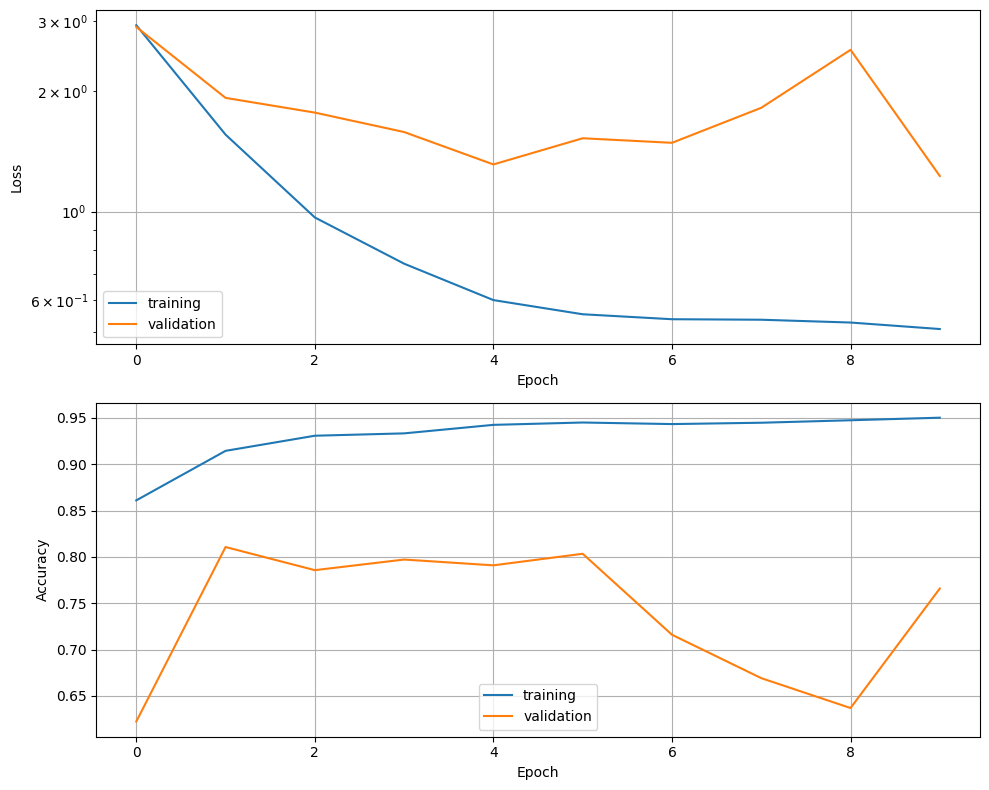

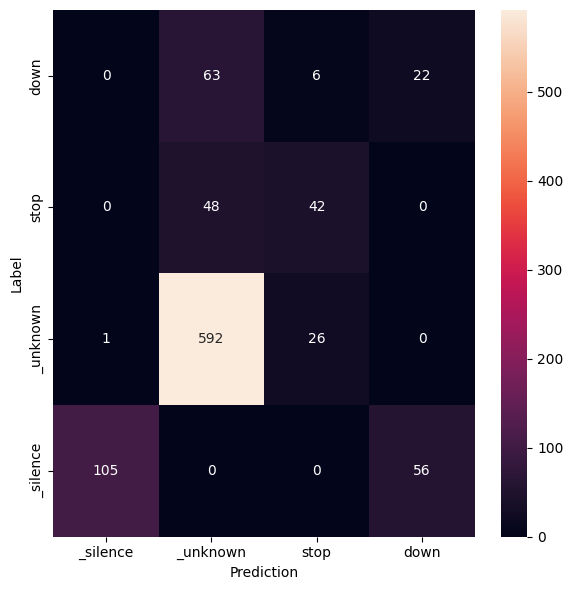

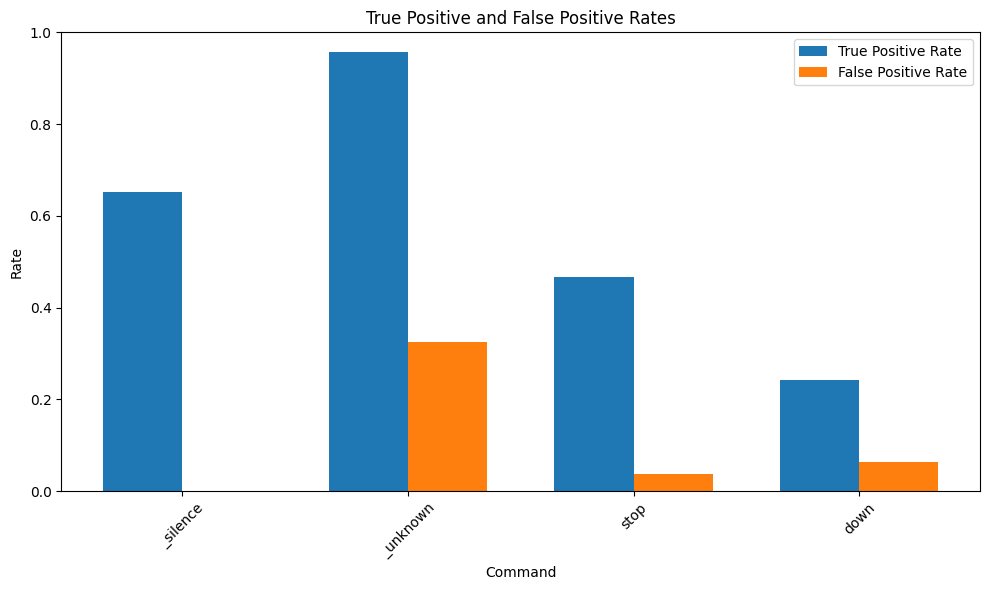

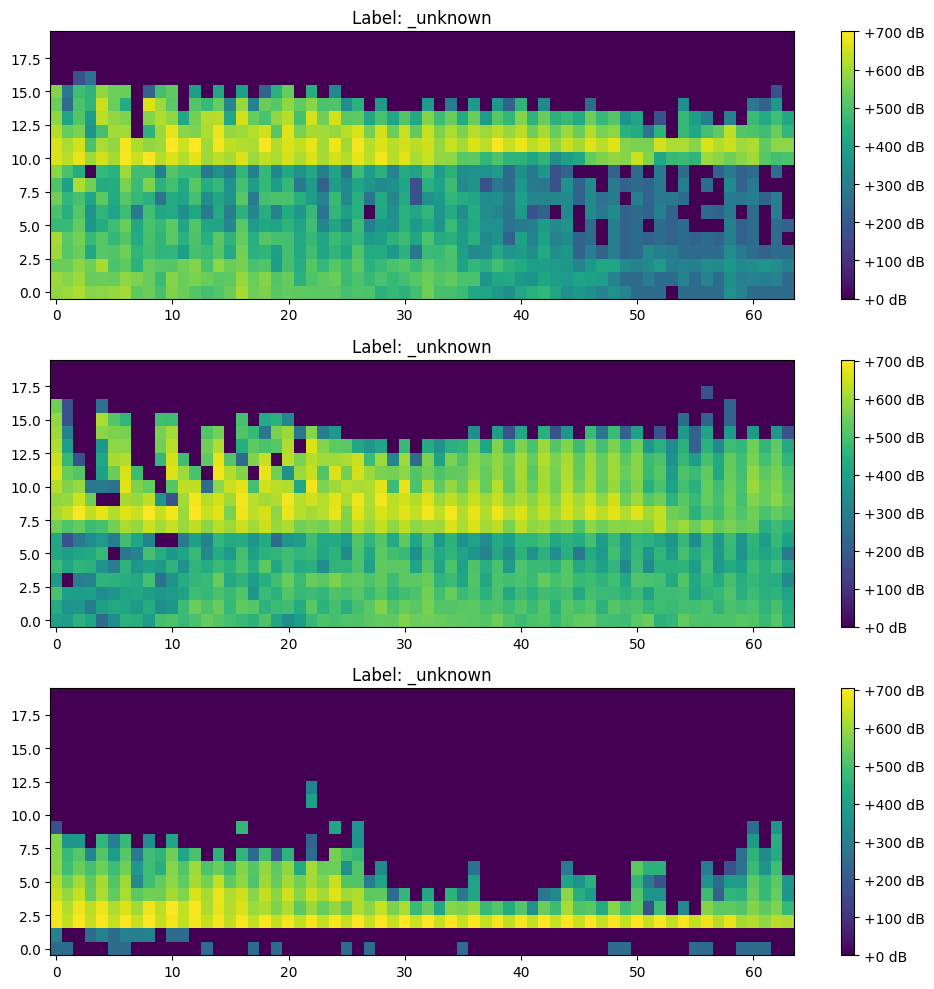

Wrote description to 25_250_model.txt


'25_250_model.txt'

In [21]:
# === Configuration ===
config.EPOCHS = 10
config.BATCH_SIZE = 32
config.LEARNING_RATE = 0.0008
config.COMMANDS = ['stop', 'down']  # choose your two keywords
config.DATASET = 'mini-speech'       # or 'full-speech-files'
config.MAX_WAVS_0 = 25
config.MAX_WAVS_1 = 250

# Print current configuration
config.print_configuration()


# === Training Pipeline ===

# Start timer
t0 = time.time()

# Get file lists
train_files, val_files, test_files = data_utils.get_files_distribution()
print(f"We have {len(train_files)}/{len(val_files)}/{len(test_files)} training/validation/test files")


# === Prepare Datasets ===

train_ds, val_ds, test_ds, input_shape = data_utils.prepare_datasets(
    train_files, val_files, test_files)


# === Build Model ===

model = modelL2Reg(input_shape, learning_rate=config.LEARNING_RATE)
model.summary()

# === Train Model ===

history = train_model(model, train_ds, val_ds, epochs=config.EPOCHS)


# === Evaluate Model ===

test_loss, test_acc, confusion_mtx, tpr, fpr = evaluate_model(model, test_ds)

# Save example spectrogram shape for info
for spectrogram, _ in train_ds.take(1):
    spectrogram_shape = spectrogram[0].shape

# === Visualizations ===

visualization.plot_training_history(history)
visualization.visualize_model_performance(confusion_mtx, tpr, fpr)
visualization.plot_example_spectrograms(train_ds)


model_file_name = f"25_250_model.h5"
save_model_info(model_file_name, test_acc, tpr, fpr, spectrogram_shape)

# Finding Minimum Samples

FFT window length = 1024
Learning rate: 0.0005
Commands: ['stop', 'down']
Label list: ['_silence', '_unknown', 'stop', 'down']
Number of total examples: 8000
Using mini-speech
Training set size 6400
Validation set size 800
Test set size 800
We have 6400/800/800 training/validation/test files
Limited samples: stop=500, down=500
Preparing datasets from 5808/800/800 files
Processing 5808 files
Added 1162 silent wavs and noisy samples
About to create spectrograms from 14970 waves
 14750 wavs processedProcessing 800 files
Added 161 silent wavs and noisy samples
About to create spectrograms from 961 waves
 750 wavs processedProcessing 800 files
Added 161 silent wavs and noisy samples
About to create spectrograms from 961 waves
 750 wavs processedInput shape: (20, 32, 1)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 18, 30, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 18, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 18, 15, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 16, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 16, 13, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 14, 11, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 14, 11, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 12, 9, 256)     │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 12, 9, 256)     │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling2d_3          │ (None, 256)            │             0 │
│ (GlobalMaxPooling2D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 390,788 (1.49 MB)

 Trainable params: 389,828 (1.49 MB)

 Non-trainable params: 960 (3.75 KB)

Epoch 1/10
468/468 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - accuracy: 0.7706 - loss: 3.3766 - val_accuracy: 0.8075 - val_loss: 2.2722
Epoch 2/10
468/468 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.9198 - loss: 1.7299 - val_accuracy: 0.9386 - val_loss: 1.1685
Epoch 3/10
468/468 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.9393 - loss: 1.0598 - val_accuracy: 0.9365 - val_loss: 0.8713
Epoch 4/10
468/468 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.9446 - loss: 0.7804 - val_accuracy: 0.9240 - val_loss: 0.7517
Epoch 5/10
468/468 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.9539 - loss: 0.6353 - val_accuracy: 0.9313 - val_loss: 0.7051
Epoch 6/10
468/468 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.9490 - loss: 0.5903 - val_accuracy: 0.9480 - val_loss: 0.6031
Epoch 7/10
468/468 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.9570 - loss: 0.5494 - val_accuracy: 0.9448 - val_loss: 0.6500
Epoch 8/10
468/468 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.9640 - loss: 0.5248 - val_acc

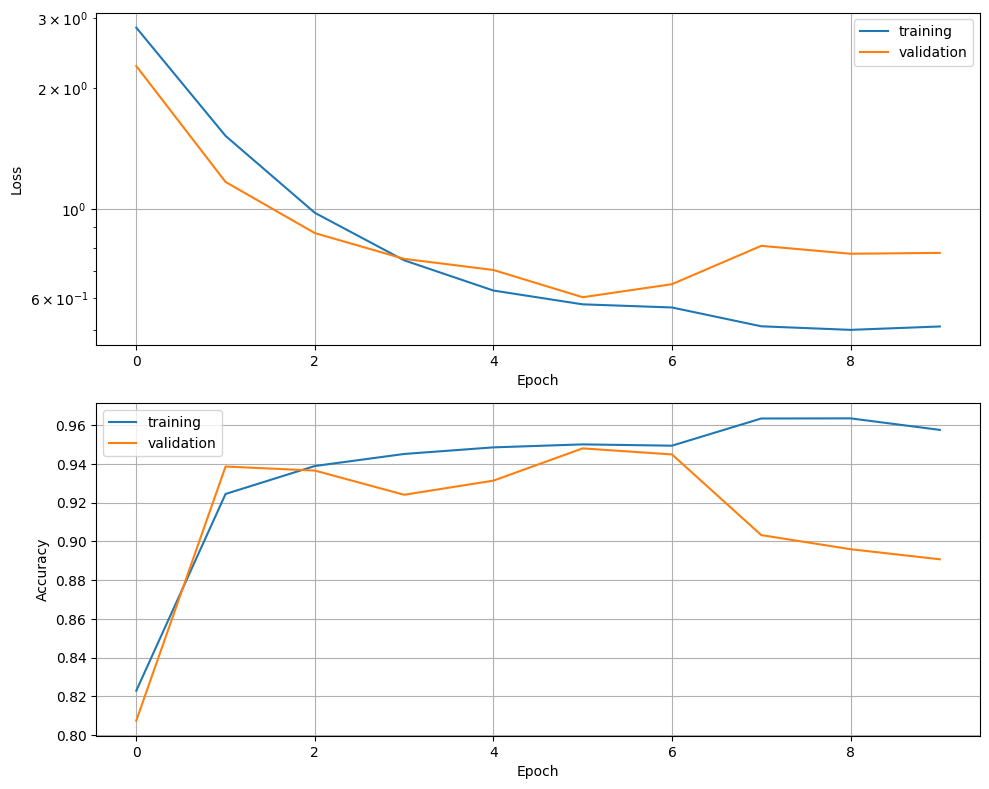

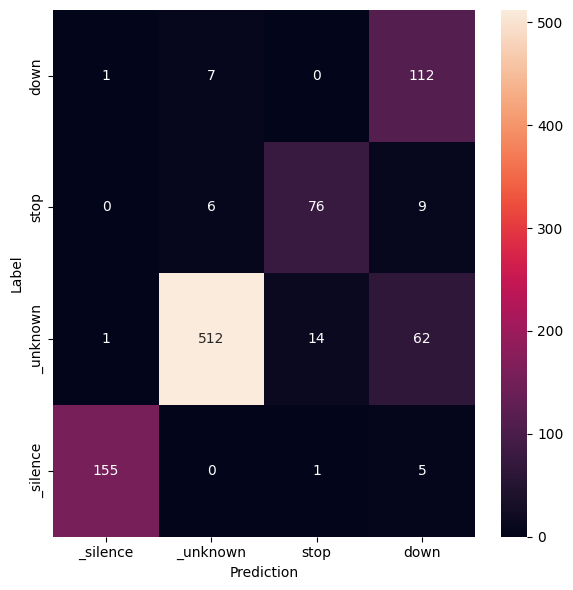

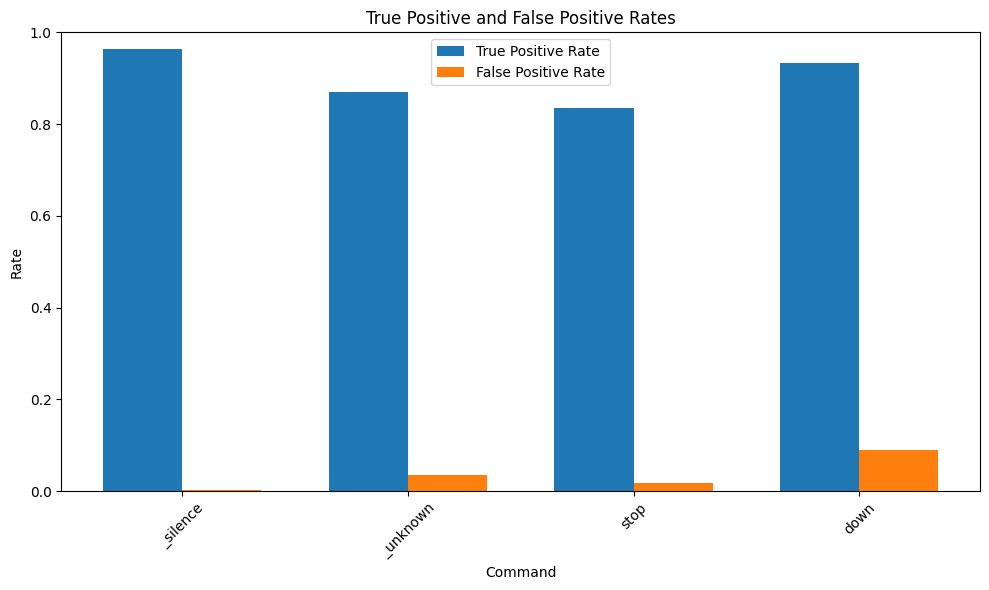

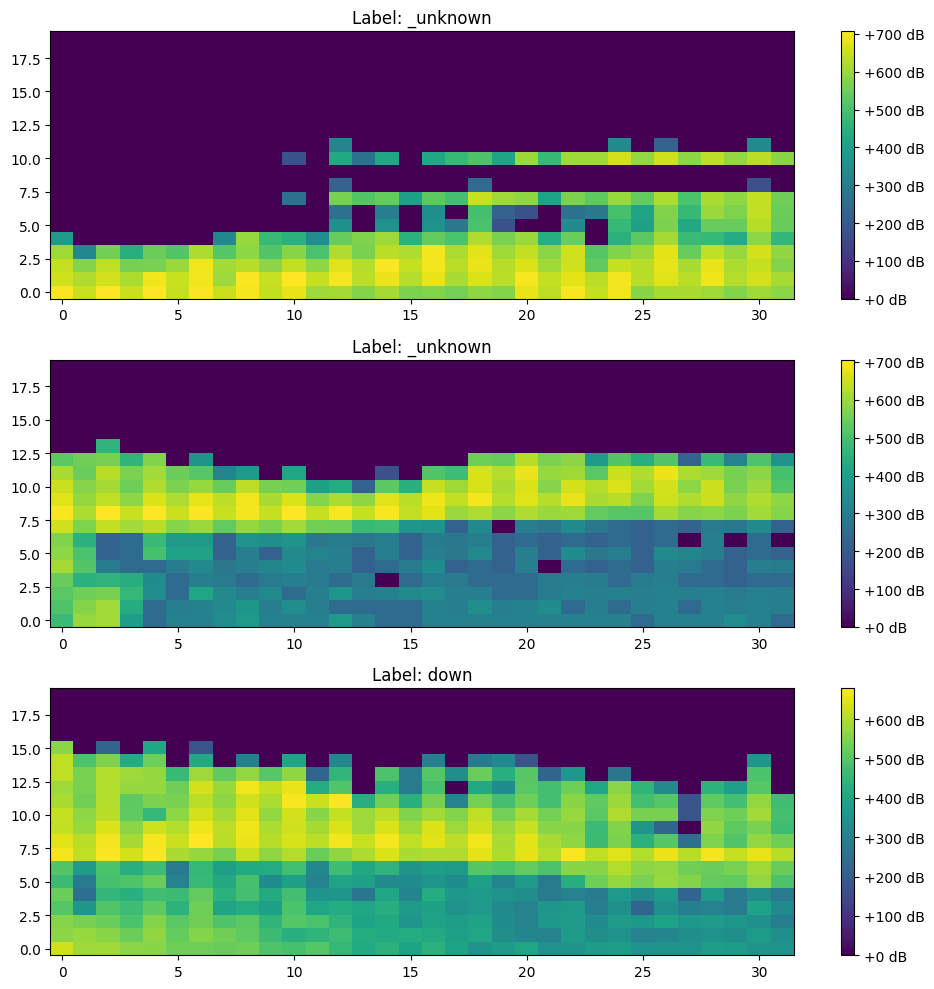

Wrote description to 25_250_model.txt


'25_250_model.txt'

In [6]:
# === Configuration ===
config.EPOCHS = 10
config.BATCH_SIZE = 32
config.LEARNING_RATE = 0.0005
config.COMMANDS = ['stop', 'down']  # choose your two keywords
config.DATASET = 'mini-speech'       # or 'full-speech-files'
config.MAX_WAVS_0 = 500
config.MAX_WAVS_1 = 500

# Print current configuration
config.print_configuration()


# === Training Pipeline ===

# Start timer
t0 = time.time()

# Get file lists
train_files, val_files, test_files = data_utils.get_files_distribution()
print(f"We have {len(train_files)}/{len(val_files)}/{len(test_files)} training/validation/test files")


# === Prepare Datasets ===

train_ds, val_ds, test_ds, input_shape = data_utils.prepare_datasets(
    train_files, val_files, test_files)


# === Build Model ===

model = modelL2Reg(input_shape, learning_rate=config.LEARNING_RATE)
model.summary()

# === Train Model ===

history = train_model(model, train_ds, val_ds, epochs=config.EPOCHS)


# === Evaluate Model ===

test_loss, test_acc, confusion_mtx, tpr, fpr = evaluate_model(model, test_ds)

# Save example spectrogram shape for info
for spectrogram, _ in train_ds.take(1):
    spectrogram_shape = spectrogram[0].shape

# === Visualizations ===

visualization.plot_training_history(history)
visualization.visualize_model_performance(confusion_mtx, tpr, fpr)
visualization.plot_example_spectrograms(train_ds)


model_file_name = f"25_250_model.h5"
save_model_info(model_file_name, test_acc, tpr, fpr, spectrogram_shape)